# 3-3 Data Research

In [ ]:
import pandas as pd
import glob

#data merging
#二手房数据整合
esf_file_pattern = '*esf_data.xlsx'
esf_files = glob.glob(esf_file_pattern)

all_esf_data = []
for file in esf_files:
    parts = file.split('_') 
    location = parts[1] # 提取位置部分
    df = pd.read_excel(file)
    new_columns_name = ['m2', 'price', 'price_per_m2']
    df.columns = new_columns_name
    df['location'] = location # 添加位置列
    all_esf_data.append(df)

esf_data = pd.concat(all_esf_data, ignore_index=True)

#租房数据整合
zu_file_pattern = '*zu_data.xlsx'
zu_files = glob.glob(zu_file_pattern)

all_zu_data = []
for file in zu_files:
    parts = file.split('_')
    location = parts[1] # 提取位置部分
    df = pd.read_excel(file)
    new_columns_name = ['m2', 'rent']
    df.columns = new_columns_name
    df['rent_per_m2'] = df['rent'] / df['m2'] # 计算每平米租金
    df['location'] = location # 添加位置列
    all_zu_data.append(df)

zu_data = pd.concat(all_zu_data, ignore_index=True)


In [2]:
#data description
def count_outliers_iqr(series):
    """使用 IQR 方法计算 Series 中的离群值数量"""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_count = ((series < lower_bound) | (series > upper_bound)).sum()
    return outliers_count

location_mapping = {
    'Balitai': '八里台',
    'Quanyechang': '劝业场',
    'Wuqing': '武清',
    'Zhongxin': '中新生态城'
}

esf_desc_stats = esf_data.groupby('location')['price_per_m2'].describe()
esf_desc_stats.rename(index=location_mapping, inplace=True)
print("\n--- 二手房 price/m2 分组统计 ---")
print(esf_desc_stats)

outlier_esf_counts = esf_data.groupby('location')['price_per_m2'].apply(count_outliers_iqr).rename('Outlier_Count')
outlier_esf_counts.rename(index=location_mapping, inplace=True)
print("\n--- price/m2 离群值数量 (基于 IQR 方法) ---")
print(outlier_esf_counts)



--- 二手房 price/m2 分组统计 ---
           count          mean           std      min       25%      50%  \
location                                                                   
八里台       1200.0  29455.316667  13430.439144  11422.0  21718.00  26074.0   
劝业场       1200.0  52628.380000  19923.620670   7422.0  39970.00  48214.0   
武清        1200.0  12492.114167   4728.726734   3633.0   9349.75  11639.5   
中新生态城     1200.0  12925.451667   4399.795984   4032.0   9288.25  12704.0   

               75%       max  
location                      
八里台       31578.00  127575.0  
劝业场       59055.50  170731.0  
武清        14499.75   53715.0  
中新生态城     15899.00   28014.0  

--- price/m2 离群值数量 (基于 IQR 方法) ---
location
八里台      105
劝业场       82
武清        63
中新生态城      7
Name: Outlier_Count, dtype: int64


通过对天津二手房数据的统计分析，首先可以观察到四个地区的房价均值有较大差异，武清和中新生态城的均值都在一万元级别，而八里台和劝业场则分别到达三万元和五万元，可以认为八里台和劝业场是整体房价更高的地段。而方差则呈现出与房价均值成正相关的规律，每平米房价均值越高的区域房价的波动也越大。中位数和均值的规律相近，依然是八里台和劝业场房价更高。  

利用IQR的方法计算离群值，得出中新生态离群值较少，房价整体分布较为集中，而其他三个地区都有较多离群值，其中八里台最多，有105个离群值

In [3]:
zu_desc_stats = zu_data.groupby('location')['rent_per_m2'].describe()
zu_desc_stats.rename(index=location_mapping, inplace=True)
print("\n--- 租房 rent/m2 分组统计 ---")
print(zu_desc_stats)

outlier_zu_counts = zu_data.groupby('location')['rent_per_m2'].apply(count_outliers_iqr).rename('Outlier_Count')
outlier_zu_counts.rename(index=location_mapping, inplace=True)
print("\n--- rent/m2 离群值数量 (基于 IQR 方法) ---")
print(outlier_zu_counts)


--- 租房 rent/m2 分组统计 ---
           count       mean        std        min        25%        50%  \
location                                                                  
八里台        614.0  46.243432  16.486070   9.016393  36.082474  43.159537   
劝业场       1167.0  69.222792  30.972729  21.428571  54.237288  62.745098   
武清        1200.0  16.232599   7.602423   3.012048  10.817098  15.868006   
中新生态城     1200.0  24.723856   6.072339   5.982906  21.652973  24.619026   

                75%         max  
location                         
八里台       52.500000  126.050420  
劝业场       73.503836  333.000000  
武清        20.661544   61.111111  
中新生态城     27.956989   71.942446  

--- rent/m2 离群值数量 (基于 IQR 方法) ---
location
八里台      39
劝业场      97
武清       22
中新生态城    51
Name: Outlier_Count, dtype: int64


通过对天津租房数据进行统计分析，首先可以看出八里台和劝业场这两个高房价地区的出租房屋数量是要明显少于另外两个地区的，说明房价高的地区人们更倾向于自住，而租房数据较少也可能会导致这两个地区的在后续租售比的回归中会不够准确。从其他数据来看，依然是八里台和劝业场两个地区的均值和中位数明显更高，同时伴随更高的方差。  

而对租房数据进行离群值分析，依然用IQR法计算，四个地区都明显有不少离群值，劝业场离群值数量（以及所占比例）最大。说明租房房价的整体波动范围都不小。

In [ ]:
# 中位数价格、租金和租售比
median_price = esf_data.groupby('location')['price_per_m2'].median().rename('median_price_per_m2')
median_rent = zu_data.groupby('location')['rent_per_m2'].median().rename('median_rent_per_m2')

median_data = pd.merge(median_price, median_rent, left_index=True, right_index=True, how='inner')
median_data['Price_Rent_Ratio'] = (median_data['median_price_per_m2'] / median_data['median_rent_per_m2'])

median_data.rename(index=location_mapping, inplace=True)

print("\n--- 中位数价格、租金和租售比 ---")
print(median_data)


--- 中位数价格、租金和租售比 ---
          median_price_per_m2  median_rent_per_m2  Price_Rent_Ratio
location                                                           
八里台                   26074.0           43.159537        604.130676
劝业场                   48214.0           62.745098        768.410625
武清                    11639.5           15.868006        733.520027
中新生态城                 12704.0           24.619026        516.023672


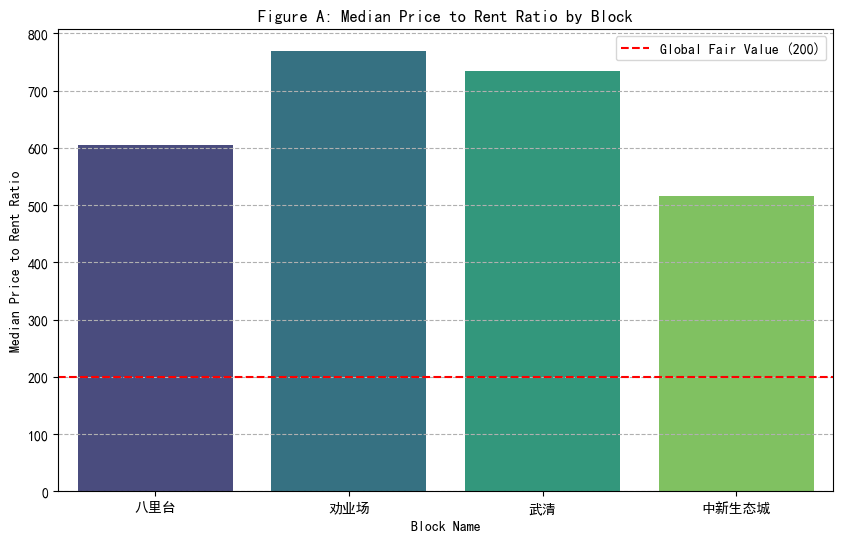

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制柱状图
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

plt.figure(figsize=(10, 6))
sns.barplot(x=median_data.index, y='Price_Rent_Ratio', data=median_data, palette='viridis', hue=median_data.index, legend=False)
plt.axhline(y=200, color='r', linestyle='--', label='Global Fair Value (200)') 
plt.title('Figure A: Median Price to Rent Ratio by Block')
plt.xlabel('Block Name')
plt.ylabel('Median Price to Rent Ratio')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.show()

# 3-4 Modeling


--- 模型调整后中位数租售比 ---


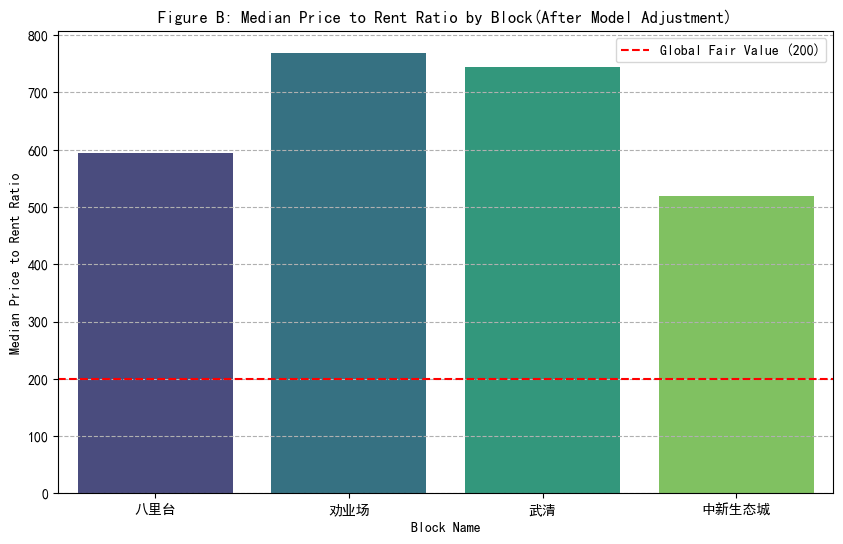

In [ ]:
import numpy as np
import statsmodels.formula.api as smf

# M1M2 回归模型
formula_1 = 'price_per_m2 ~ m2 + C(location)'
model_1 = smf.ols(formula=formula_1, data=esf_data).fit()

formula_2 = 'rent_per_m2 ~ m2 + C(location)'
model_2 = smf.ols(formula=formula_2, data=zu_data).fit()

# 用模型预测
esf_data['rent_per_m2'] = model_2.predict(esf_data)
zu_data['price_per_m2'] = model_1.predict(zu_data)

# 重新计算租售比
combined_data = pd.concat([esf_data, zu_data], join ='inner', ignore_index=True)
combined_data['Price_Rent_Ratio'] = combined_data['price_per_m2'] / combined_data['rent_per_m2']
median_price_rent_ratio = combined_data.groupby('location')['Price_Rent_Ratio'].median().rename('Median_Price_Rent_Ratio')
median_price_rent_ratio = median_price_rent_ratio.rename(index=location_mapping)

# 绘制柱状图
print("\n--- 模型调整后中位数租售比 ---")
plt.figure(figsize=(10, 6))
sns.barplot(x=median_price_rent_ratio.index, y=median_price_rent_ratio, palette='viridis', hue=median_price_rent_ratio.index, legend=False)
plt.axhline(y=200, color='r', linestyle='--', label='Global Fair Value (200)') 
plt.title('Figure B: Median Price to Rent Ratio by Block(After Model Adjustment)')
plt.xlabel('Block Name')
plt.ylabel('Median Price to Rent Ratio')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.show()

In [ ]:
# M1+ M2+ 回归模型
formula_1_plus = 'price_per_m2 ~ m2 + I(m2**2) + C(location) + C(location):m2'
model_1_plus = smf.ols(formula=formula_1_plus, data=esf_data).fit()

formula_2_plus = 'rent_per_m2 ~ m2 + I(m2**2) + C(location) + C(location):m2'
model_2_plus = smf.ols(formula=formula_2_plus, data=zu_data).fit()

print("\n--- 模型M1+系数报告 ---")
print(model_1_plus.params)
print("\n--- 模型M2+系数报告 ---")
print(model_2_plus.params)



--- 模型M1+系数报告 ---
Intercept                        19076.274509
C(location)[T.Quanyechang]       43661.238764
C(location)[T.Wuqing]            -3661.646241
C(location)[T.Zhongxin]          -2004.300980
m2                                  50.487564
C(location)[T.Quanyechang]:m2     -245.109532
C(location)[T.Wuqing]:m2          -111.607752
C(location)[T.Zhongxin]:m2        -122.497922
I(m2 ** 2)                           0.272327
dtype: float64

--- 模型M2+系数报告 ---
Intercept                        53.466371
C(location)[T.Quanyechang]       24.128105
C(location)[T.Wuqing]           -22.871730
C(location)[T.Zhongxin]         -17.905852
m2                               -0.165612
C(location)[T.Quanyechang]:m2    -0.028757
C(location)[T.Wuqing]:m2         -0.041047
C(location)[T.Zhongxin]:m2       -0.002346
I(m2 ** 2)                        0.000563
dtype: float64


In [ ]:
# R² 比较
r_squared_1 = model_1.rsquared
r_squared_2 = model_2.rsquared
r_squared_1_plus = model_1_plus.rsquared
r_squared_2_plus = model_2_plus.rsquared

print("\n--- 回归模型 R² 比较 ---")
print(f"Model 1 R²:      {r_squared_1:.4f}")
print(f"Model 1+ R²:     {r_squared_1_plus:.4f}\n")
print(f"Model 2 R²:      {r_squared_2:.4f}")
print(f"Model 2+ R²:     {r_squared_2_plus:.4f}")


--- 回归模型 R² 比较 ---
Model 1 R²:      0.6340
Model 1+ R²:     0.6961

Model 2 R²:      0.5837
Model 2+ R²:     0.5979


两个模型在加入二次项和交叉项以后都取得了更高的R方，说明模型对样本波动的解释性得到了增强。首先分析二次项的作用，模型中二次项系数为正，刻画了在大面积房屋中随着面积的增大，房屋单价出现边际递增的趋势，这是符合经济学直觉的，因为大面积的房屋的总价更高，筛选出的客户有着更强的经济实力，有较强的意愿为了更好的生活体验来支付更高的价格，而且大面积的房屋往往在更好的地段，会有更多的来自其他因素的溢价。因此加入二次项可以更好的刻画实际情况。而交互项就更好解释了，因为不同地段对于房屋的加成是不一样的，因此加入交互性可以刻画出不同地段下面积增加带来的边际收益差异。


--- 模型plus调整后中位数租售比 ---


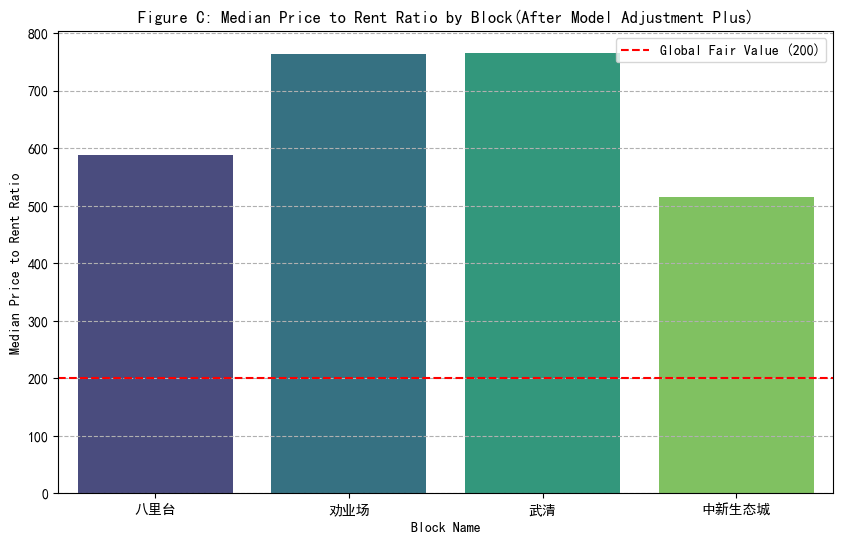

In [ ]:
# 用M1+ M2+模型预测数据
esf_data['rent_per_m2'] = model_2_plus.predict(esf_data)
zu_data['price_per_m2'] = model_1_plus.predict(zu_data)

# 重新计算租售比
combined_data = pd.concat([esf_data, zu_data], join ='inner', ignore_index=True)
combined_data['Price_Rent_Ratio'] = combined_data['price_per_m2'] / combined_data['rent_per_m2']
median_price_rent_ratio_plus = combined_data.groupby('location')['Price_Rent_Ratio'].median().rename('Median_Price_Rent_Ratio')
median_price_rent_ratio_plus = median_price_rent_ratio_plus.rename(index=location_mapping)

# 绘制柱状图
print("\n--- 模型plus调整后中位数租售比 ---")
plt.figure(figsize=(10, 6))
sns.barplot(x=median_price_rent_ratio_plus.index, y=median_price_rent_ratio_plus, palette='viridis', hue=median_price_rent_ratio_plus.index, legend=False)
plt.axhline(y=200, color='r', linestyle='--', label='Global Fair Value (200)') 
plt.title('Figure C: Median Price to Rent Ratio by Block(After Model Adjustment Plus)')
plt.xlabel('Block Name')
plt.ylabel('Median Price to Rent Ratio')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.show()

In [ ]:
# 比较三种方法得出的租售比
comparison_df = pd.DataFrame({
    'Simple Median': median_data['Price_Rent_Ratio'],
    'Model Method': median_price_rent_ratio,
    'Model+ Method': median_price_rent_ratio_plus
})
print("\n--- 三种方法中位数租售比比较 ---")
print(comparison_df)


--- 三种方法中位数租售比比较 ---
          Simple Median  Model Method  Model+ Method
location                                            
八里台          604.130676    593.271070     588.204288
劝业场          768.410625    767.877299     763.166969
武清           733.520027    744.286241     764.484948
中新生态城        516.023672    519.190732     515.873062


分析三种方法计算出的租售比，从数值上来讲差距并不大，但也存在明显规律：对于高房价地段（八里台、劝业场），通过回归分析所得到的中位租售比会更低，且随着模型拟合度提升租售比估计值降低；而低房价地段则表现出了相反的规律。尝试分析这个规律背后的原因，可能是由于过高或过低房价的业主都不会选择出租而是以自住为主，因此二手房和租房的中位数并不匹配，而模型拟合后可以消除这一错配问题。从数据量来说，4000左右的数据量已经可以较好地拟合出回归系数，同时M1+和M2+回归方程的R方也0.6以上，因此我认为最后一个模型的拟合结果是最为可信的。